# Do prison reform programs reduce recidivism? 

## Goals

In previous cases we discussed the importance of randomization in the design of experiments for causal analysis. We mentioned that randomization is a gold standard if we want to avoid erroneous or skewed results in our experiments. However, in many instances, conducting an experiment with a pure random treatment group and control group is not feasible (this may be due to ethical or constrained resource issues). In this case, you will learn how *matching* can help to alleviate this problem.

In [1]:
from plotly.offline import init_notebook_mode, plot
import numpy as np
import numpy.random as nr
from numpy.linalg import norm
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Introduction

**Business Context.** Recidivism is a measure of a former prisoner's likelihood to be re-arrested, re-convicted, or returned to prison with or without a new sentence during a three-year period following the prisoner's release. It has been used to study the performance and effectiveness of privately and publicly managed prisons. Recidivism rates among prisoners in the United States are high, with more than 60% of released prisoners re-offending within three years of release.

Consequently, prison reform programs have invested hundreds of millions of dollars per year on programs designed to reduce re-offense. However, implementing these programs is costly and evaluating them can be complex. Currently, policymakers are interested in evaluating a training program designed to reduce recidivism among paroled inmates. They have come to you for assistance in determining whether it is worthwhile.

**Business Problem.** The policymakers want you to answer the following: **"Will there be a reduction in recidivism if the proposed program were to be widely adopted?"**  

**Analytical Context.** The new program was piloted for a subset of parolees (recently released prisoners) from two prisons. New parolees at these two prisons were given the option to volunteer to participate in the recidivism reduction program. If we determine that the program is worthwhile, it would subsequently be scaled to all parolees from twenty-five eligible prisons in the federal penal system.

The case is structured as follows: you will (1) analyze the setup of the program and identify potential observational study design problems; (2) learn about matching and use it to correct for some of these problems; and finally (3) conduct exploratory data analysis to determine which features seem to account for most of the corrections/differences between the policymakers' study and our matched study.

## Initial analysis of the program

The program we are evaluating in this case study was focused on vocational training and coping skills and was applied to  $n = 7105$ parolees from 2013 - 2015 in the southeastern United States. Participants were followed for 30 months after completing the program and identified as a "responder" if they did not commit a serious offense during that period, and a "non-responder" if they did. The data collected in the study has the form $(\mathbf{X}_1,\mathbf{Y}_1),(\mathbf{X}_2,\mathbf{Y}_2),\dots, (\mathbf{X}_n,\mathbf{Y}_n)$, where $\mathbf{X}_i$ is a vector containing several characteristics of parolee $i$ and $\mathbf{Y}_i\in\{0,1\}$ is a binary variable recording whether parolee $i$ was a responder or not (1 meaning re-offended, 0 meaning did not re-offend). Parolee characteristics are as follows:

| Variable | Description|
|----|------------------|
|ID  | Unique prisoner identifier|
|Max severity | (1-5) Severity of most serious charge in current conviction |
|Ave severity | (1-5) Average severity across all charges in currennt conviction| 
|Sentence time| Sentence length (months) assigned|
|Sentence served| Time served (months)| 
| Education | (1-4) coded so that: 1 - less than High School, 2 - High School, 3 - Some College, and 4 - College Degree|  
| Repeat offender| Binary indicator of previous conviction | 
| Substance use | Binary indicator of substance  abuse | 
| Support | Binary indicator that parolee is being provided with transitional  support (e.g., halfway house)| 

In [2]:
study_data_pd = pd.read_csv('rec_study.csv')
study_data_pd.head()

max_severity  ave_severity  sentence_time  sentence_served  \
0             1      1.000000      15.281172         4.032279   
1             1      1.000000      19.816019         1.625926   
2             2      1.333333      59.293718        38.978041   
3             2      1.333333      72.026361        25.082745   
4             1      1.000000      10.618477         9.412762   

   repeat_offender  substance_use  support  education  reoffend  
0                0              0        1          1         1  
1                0              0        0          1         0  
2                0              1        1          1         1  
3                1              0        0          4         0  
4                0              0        0          4         0

### Exercise 1:

What is one potential issue you see with the program design that might dilute the conclusiveness of your results?

**Answer.**

### Exercise 2:

Conduct a basic exploratory data analysis to see if any of the covariates appear to be related to the probability of re-offense. What is the average rate of re-offense of the participants in the study?

**Answer.**

----------

### Exercise 3:

A reduction of 12.5% *would* be remarkable *if* such results held across all prisoners released across the entire prison system. Recall that policy makers are interested in the value of a program if it were instituted across the entire system. Can you identify any sources of bias that might prevent the study from generalizing to the entire prison system?

**Answer.**

----------

Let's assume now that the two sampled prisons are *not* systematically different from the others.

### Exercise 4:

Given that the set of prisoners who opt into the program could be biased, suggest three possible approaches to estimate the response rate in the entire population of released prisoners. Discuss the costs and benefits of these approaches.

**Answer.**

---------

## Causal analysis via matching

The core idea of matching is to group untreated individuals with treated individuals (here, the treatment is the recidivism reduction program) based on similarities in measured covariates to estimate the effect of treatment across the entire population. Assume that in addition to the *in-study data*, $ (\mathbf{X}_1, \mathbf{Y}_1),\dots,  (\mathbf{X}_n, \mathbf{Y}_n)$ we have data from $m=55799$ prisoners released during the study period that either opted out of the study or were not eligible because they were not at one of the two prisons included in the study. Let us denote the characteristics of these *out of study* prisoners by $\mathbf{X_1'}, \mathbf{X_2'}, \dots, \mathbf{X_m'}$.

Informally, for each *out of study* prisoner $j\in \{1, \dots, m\}$ with characteristics $\mathbf{X}_j'$, our objective is to find an *in study* prisoner $i\in\{1,\dots, n\}$ with characteristics $\mathbf{X}_i$, such that $\mathbf{X}_i$ and $\mathbf{X}_j'$ are as close as possible according to some **measure of distance**.  The intuition here is that if prisoner $i$ re-offended (i.e. $\mathbf{Y}_i=1$) and $\mathbf{X}_i$ is close to $\mathbf{X}_j'$, then it is reasonable to estimate that the *out of study* prisoner $j$ will re-offend as well. Of course, this analysis is highly dependent on the measure we choose and some thought should be taken when selecting the appropriate measure. 
    
For the purposes of this case, we will use the **euclidean distance**. Recall that given a pair of vectors $X=(x_1,\dots, x_p)$ and $X'=(x_1',\dots, x_p')$, the euclidean distance between $X$ and $X'$ is the value
$$
d(X,X'):=\sqrt{(x_1-x_1')^2+(x_2-x_2')^2+\dots+(x_p-x_p')^2}.
$$
Thus, for each out-of-study prisoner $j$, our matching algorithm should find the in-study prisoner $i$ with $d(\mathbf{X}_i,\mathbf{X'}_j)$ as small as possible.
    
After matching, we will compute the mean recidivism rate for the matched sample. This form of matching is called **nearest-neighbor-one matching (KNN-1)** and is among the most popular and intuitive variants of matching.

The characteristics of the out-of-study prisoners are stored in the csv file `rec_popn.csv`. Let's first read in the `rec_study.csv` data into a dataframe called `in_study_data`, then read in `rec_popn.csv` into a dataframe called `out_of_study`:

In [6]:
in_study_data = pd.read_csv('rec_study.csv') 
n, p = np.shape(in_study_data) 
out_of_study_data =  pd.read_csv('rec_popn.csv')
m, q = out_of_study_data.shape

Before proceeding with the matching, it is important that we scale properly the different features of our data! (**Why?**) There exist various methods used for *feature scaling*, some popular options are *min-max normalization, standardization* and *scaling to unit length*.

Here will scale each feature so that the columns of our data have unit length. We can do this using the function ```norm``` from [```numpy.linalg```](https://stackoverflow.com/questions/9171158/how-do-you-get-the-magnitude-of-a-vector-in-numpy): 

In [7]:
in_study_norm = norm(in_study_data.iloc[:,0:8], axis=0)
in_study_data.iloc[:,0:8]/= in_study_norm
out_of_study_data/=  in_study_norm

In order to get a *graphical idea* of what our matching will do, let us pick 100 random out-of-study prisoners to merge in our data and make a simple scatter plot:

<IPython.core.display.Javascript object>


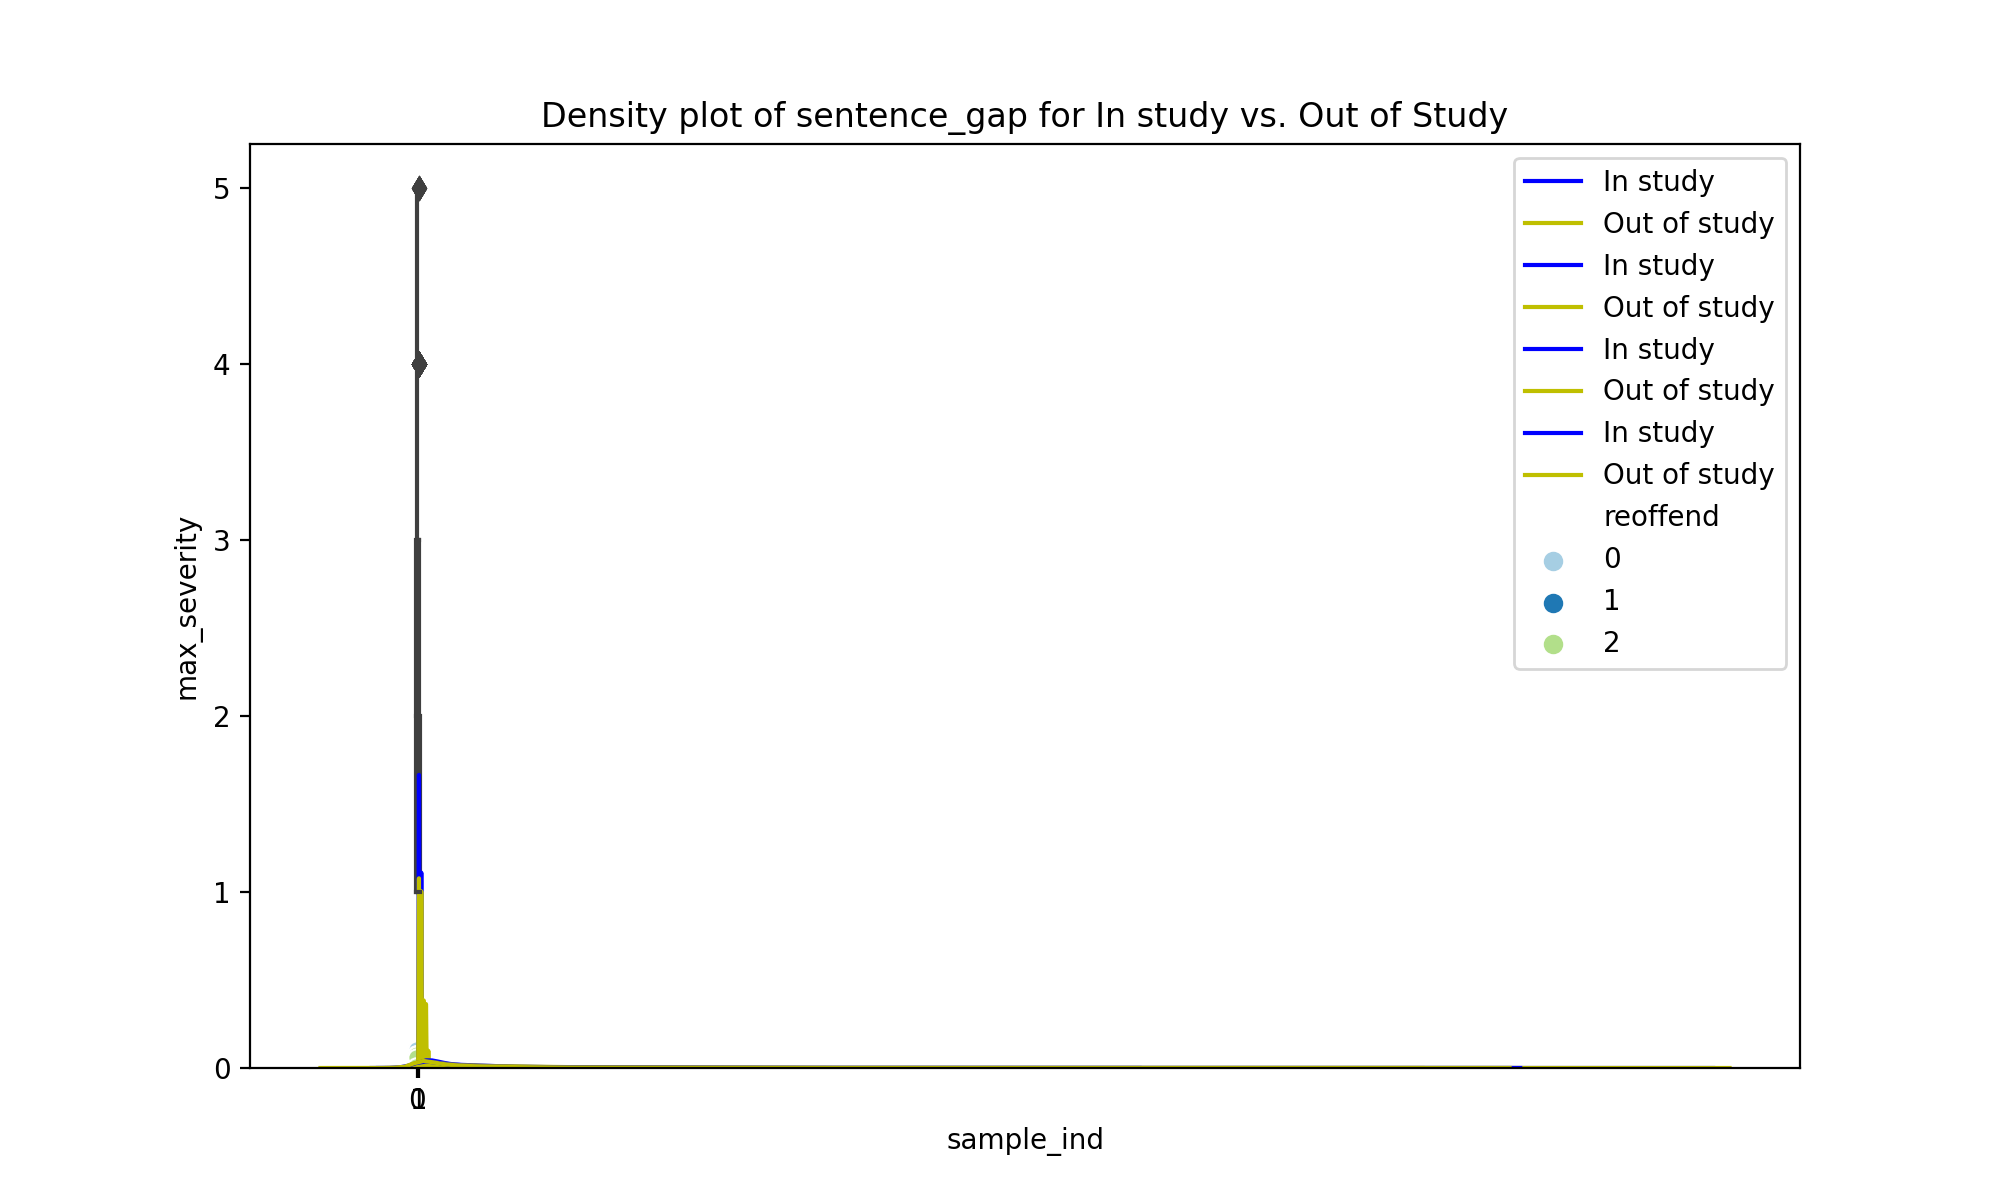

In [8]:
#Select 10 random out-of-study prisoner
np.random.seed(0)
random_subset=np.random.randint(0,m-1,100)

#merge with the 
all_data=pd.concat([in_study_data,out_of_study_data.iloc[random_subset,:]],sort=True)
all_data=all_data.fillna(2)
all_data['reoffend']=all_data['reoffend'].astype('int')

#Plot sentence_time and ave_severity features of the prisoners
%matplotlib notebook
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentence_time',y='sentence_served',hue='reoffend',data=all_data,palette='Paired')

Notice that, if we judge only by the sentence time vs. sentence served features, there are a few out-of-study prisoners that we could consider as potential re-offenders (the ones closer to the orange dots) or potential responders (the ones closer to the blue dots). But, if we zoom in on some parts of the plot, there are some instances where it is hard to tell how to classify them.

### `tqdm` package

Sometimes, you will have to use for-loops, even if they are not efficient. You can use the `tqdm` package to get an estimate of how long it will take for stuff to run: 

In [9]:
from tqdm.auto import tqdm, trange
for j in trange(1000000, desc = "Iterating"):
    if j%50000 == 0:
     print("Finished " + str(j) + " iterations")

Finished 0 iterations
Finished 50000 iterations
Finished 100000 iterations
Finished 150000 iterations
Finished 200000 iterations
Finished 250000 iterations
Finished 300000 iterations
Finished 350000 iterations
Finished 400000 iterations
Finished 450000 iterations
Finished 500000 iterations
Finished 550000 iterations
Finished 600000 iterations
Finished 650000 iterations
Finished 700000 iterations
Finished 750000 iterations
Finished 800000 iterations
Finished 850000 iterations
Finished 900000 iterations
Finished 950000 iterations



### Exercise 5:

Write code to create the matched data set for the first 10000 rows of the normalized out-of-study data using the normalized in-study data. (It may take a while to run, so you can use `tqdm` to track your progresss.) Once you have completed the matching, compute the estimated matched mean.

**Hint:** You could run a loop using the formula provided, but this might be expensive (try it yourself). If you know a little about matrices you could use the following  to speed up your computation:

If $X$ is an $n\times k$ matrix and $Y$ is an $m\times k$ matrix, the squared euclidean distance between the i-th row of $X$ and the $j$-th row of $Y$ equals the $ij$-entry of the matrix:
$$
M=norm(X)\cdot ones(m)^\top-2X\cdot Y^\top+ones(n)\cdot norm(Y)^\top,
$$
where $norm(X)$ is the vector of **squared** norms of each row of $X$ and $ones(p)$ is an all ones column vector of length $p$.  

**Answer.**

---------

## Looking at differentials in certain features

To begin, let's consider inclusion in the study as a binary classification problem, wherein a subject is labeled as a "1" if they were included in the study and "0" if they were not. To explore differences in the study and non-study populations, we can consider building a model that predicts whether or not a subject was in the study using their baseline covariates. As a first step in building such a predictive model, though, let's do some basic exploratory data analysis and look at distributions of the covariates.

### Exercise 6:

#### 6.1

Create a new column on both the datasets `rec_study.csv` and `res_popn.csv`; call it `sample_ind`. This column should take the value "1" for `rec_study.csv` data and "0" for `res_popn.csv` data. Merge them into a single dataset using outer merge. 

**Note:** Do not use the normalized data for this exercise.

**Answer.**

---------

####  6.2

Create two plots: a boxplot of max severity for the two datasets, and a density plot of max severity for each severity bucket (1 - 5) for the two datasets (use `sns.kdeplot()`). What can you conclude?

**Answer.**

---------

####  6.3

Compare the distributions of the remaining variables for in-study vs. out-of-study. Also, look at the distribution in the sentence gap: sentence time minus sentence served.

**Answer.**

---------

## Conclusions

We examined matching as a means of analyzing the effectiveness of an observational recidivism study. We see that even though the study looked promising on the study population, this was primarily due to factors driving selection into the study. After adjusting for these factors, the program no longer appeared to be effective. We implemented the matching algorithm based on Euclidean distance between covariates.

## Takeaways

In this case, we saw that one must take great care in analyzing observational data and pay particular attention to factors driving the construction of such studies. We learned that:

1. Sampling and treatment assignment methodology are key, as lack of prudence in these steps can lead to significant differences between the in-study and out-of-study data points.

2. Matching is one potential approach to analyzing such data. It is a conceptually simple approach but is also crude in that it does not weight covariates in terms of their importance for sample selection.

3. Several measures of distance can be used. In the future, it will be good to look at matching algorithms that weight covariates differently based on sensitivity to the objective variable.

Throughout this case we also covered some mathematical notions and manipulations that can be intimidating at first. Come back at this notebook at your own pace if you feel you need to. Remember, ask as many questions as possible to your instructors! 